### This notebook
builds a graph-based embedding for a small number of random handwritten digits with multidimensional scaling.

Optional: run this before import to recompile c++ ops
```
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c
```


##### Get the dataset:

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "..")
import lib
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from IPython.display import clear_output

X, y = load_digits(return_X_y=True, n_class=5)
X = X / np.square(X).sum(-1, keepdims=True) ** 0.5
X, y = X[:128], y[:128]

##### Build initial graph

We initialize prodige with a full graph initialized with distances between nodes

In [2]:
from lib.task.compression import make_graph_from_vectors
emb = make_graph_from_vectors(
    X, knn_edges=100, max_length=10, n_jobs=-1, soft=True, directed=False,
)
opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)

distances = np.square(X[None, :, :] - X[:, None, :]).sum(-1)
loss_history, reg_history = [], []
batch_size = 64

# uncomment to deliberately mess with weights for testing purposes
# emb.edge_weight_logits.reset_parameters()
# emb.edge_adjacency_logits.reset_parameters()

##### Training loop

Here we minimize the MDS loss function
$$L = 1/N \sum_{i, j} (d_{orig}(x_i, x_j) - d_G(v_i, v_j))^2$$

* $d_{orig}(x_i, x_j)$ is the original distance between two vectors in $X$
* $d_G(v_i, v_j)$ is the learned graph distance between corresponding vertices in graph $G$

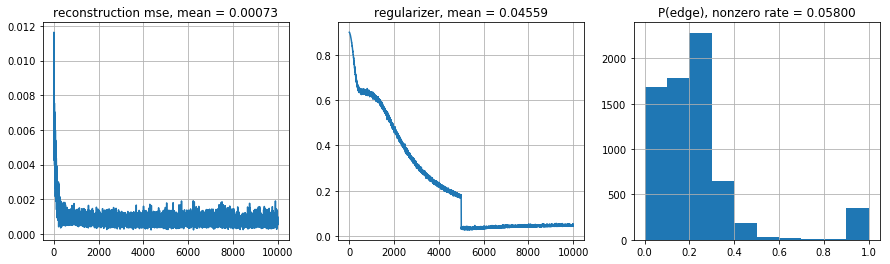

In [5]:
for batch_i in range(len(loss_history), 10000):
    ii = torch.randint(0, len(X), [batch_size])
    jj = torch.randint(0, len(X), [batch_size])

    pred = emb(ii, jj)
    distances_ref = torch.as_tensor(distances[ii, jj], dtype=torch.float32)
    
    reconstruction_mse = F.mse_loss(pred['target_distances'], distances_ref)
    
    if len(loss_history) < 5000:
        regularizer = emb.compute_l0_prior_penalty(batch_size=4096)
    else:
        regularizer = emb.compute_hierarchical_prior_penalty(nonzero_rate=0.05, batch_size=4096)

    lambd = min(1, len(loss_history) / 5000.) * 10.0
    loss = reconstruction_mse - pred['logp_target_paths'].mean() + lambd * regularizer
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(reconstruction_mse.item())
    reg_history.append(regularizer.item())
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[15, 4])
        plt.subplot(1, 3, 1);
        plt.title('reconstruction mse, mean = %0.5f' % np.mean(loss_history[-100:])); plt.grid()
        plt.plot(loss_history)
        
        plt.subplot(1, 3, 2);
        plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
        plt.plot(reg_history)

        plt.subplot(1, 3, 3);
        probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().flatten()
        nnz_rate = np.mean(probs > 0.5)
        plt.title('P(edge), nonzero rate = %.5f' % nnz_rate); plt.grid();
        plt.hist(probs)
        plt.show()

In [8]:
print(emb)

GraphEmbedding(128 vertices, 7000 edges total, 406 edges kept, 0.942 sparsity rate, default distance = 100.0)


In [6]:
from bokeh import io
io.reset_output()
io.output_file('graph.html')
emb.default_distance.data[...] = 100
lib.visualize_embeddings(emb, vertex_labels=y, edge_probability_threshold=0.5, deterministic=True,
                         vertex_alpha=0.8, cmap=lambda x: plt.get_cmap('rainbow')(x))

Figure(id='08722f66-86f9-4644-843f-da8e0a62d866', ...)

In [7]:
from IPython.display import HTML
HTML(filename="graph.html")
# re-run several times to get different tsne optima

```

```

```

```

```

```

```

```

```

```
